<br>

# NLP Word2vec and Bigram

<br>


In [24]:
import nltk
import gensim
import sklearn
import tensorflow as tf
import pandas as pd
import numpy as np
import string
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

%matplotlib inline

<br>

## Load the corpus 

In [3]:
gberg_sents = nltk.corpus.gutenberg.sents() 
# stpwords_punctuation = nltk.corpus.stopwords.words('english') + list(string.punctuation)

<br>

## Convert the sentences to lowercase 

In [4]:
lower_sents = []

for sentence in gberg_sents:
    lower_sents.append([w.lower() for w in sentence if w not in list(string.punctuation)]) 
    
# In case you want to work with numpy array 
np_lower_sents = np.asarray(lower_sents) 

<br>

#### Observation

- In the 2011 paper by amass et al, that they were taking IMDB movie sentiment data,they did not remove stop words because they think that particular stop words are indicative of sentiment and they also elected not to stem because they said that a word2vec model will learn similar representations of words of the stem whenever the data is suggested. So for this task we're gonna leave in stopwords and we are not going to stem. <br> [Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf)

<br>

<br>

<br>

## Handle biagrams collocations
Bi-grams are words that occur next to each other, so that they should be brought along together. Phrases like "Thank you" or "New York City" are seperated words but we want to treat them as a single concept.

In [5]:
bigram =  gensim.models.phrases.Phraser(gensim.models.phrases.Phrases(lower_sents, min_count=32, threshold=64))

bigram.phrasegrams

{(b'miss', b'taylor'): 156.44059469941823,
 (b'mr', b'woodhouse'): 82.04651843976633,
 (b'mr', b'weston'): 75.87438262077481,
 (b'mrs', b'weston'): 160.68485093258923,
 (b'great', b'deal'): 93.36368125424357,
 (b'mr', b'knightley'): 161.74131790625913,
 (b'miss', b'woodhouse'): 229.03802722366902,
 (b'years', b'ago'): 74.31594785893046,
 (b'mr', b'elton'): 121.3990121932397,
 (b'dare', b'say'): 89.94000515807346,
 (b'frank', b'churchill'): 1316.4456593286038,
 (b'miss', b'bates'): 276.39588291692513,
 (b'drawing', b'room'): 84.91494947493561,
 (b'mrs', b'goddard'): 143.57843432545658,
 (b'miss', b'smith'): 73.03442128232508,
 (b'few', b'minutes'): 204.16834974753786,
 (b'john', b'knightley'): 83.03755747111268,
 (b'don', b't'): 250.30957446808512,
 (b'good', b'natured'): 88.69936184891343,
 (b'few', b'moments'): 107.77584531675087,
 (b'thousand', b'pounds'): 166.51834523092802,
 (b'o', b'clock'): 89.14789088153573,
 (b'jane', b'fairfax'): 654.5565917587609,
 (b'miss', b'fairfax'): 196.

<br>

#### Observation

- (b'some', b'moments'): 21.006148097826088
    - **21.006148097826088** is Score which represents how often these words(some, moments) occured together in the corpus. If the number is big it means they occur together a lot and if it's small it means the opposite.
    
    
- We don't include stop words, because we want to train the bi-gram on our stopwords as well. The reason is that some of the stop words could end up being important pairs.


- Some of these biagrams should be retained. And some of them are not really biagrams like (b'doesn', b't'): 106.2634985949418.  they should treated seperately not as a single biagram. We need to set a new threshold.

    - **min_count:** The number of times that bigrams like (b'five', b'years') occured next to each other.
    - **threshold:** It is the score for threshold. If the number is big it means they occur together alot and if it's small it means the opposite.


In [8]:
clean_sents = []
for sentence in lower_sents:
    clean_sents.append(bigram[sentence])

In [9]:
clean_sents[6]

['sixteen',
 'years',
 'had',
 'miss_taylor',
 'been',
 'in',
 'mr_woodhouse',
 's',
 'family',
 'less',
 'as',
 'a',
 'governess',
 'than',
 'a',
 'friend',
 'very',
 'fond',
 'of',
 'both',
 'daughters',
 'but',
 'particularly',
 'of',
 'emma']

<br>

#### Observation
- Now we can see that in then $6^{th}$ sentence, `miss_taylor` or `mr_woodhouse` are treated as bi-grams.

<br>


In [10]:
model = gensim.models.word2vec.Word2Vec(sentences=clean_sents, 
                                        size=64, 
                                        sg=1, 
                                        window=10, 
                                        min_count=10, 
                                        seed=42, 
                                        workers=4)

# Save the model
model.save('clean_guttenberg_model.w2v')

# Load the model
model = gensim.models.Word2Vec.load('clean_guttenberg_model.w2v')


<br>

#### Observation

- **size:** how many dimensions we have


- **sg:(Skip-Gram)** we use skip_gram algorithm which is not default, but since it's a small dataset, skip_gram should be fine. 
    - **Skip-Gram:** It predicts the context words given the target word in the middle. 
    - **CBOW(continuous Bag of Words):** It predicts the target word from the bag of all context words. It's the inverse of skip_gram.
    
    
- **window:** Here window size is 10. it means we'll have 20 context words, 10 to the right and 10  to the left of any given target word


- **min_counts:** we only want to run the word2vec algorithm on words that appear at least 5 times in our corpus


- **workers:** how many cores on the machine should be dedicated for this task


- **seed:**  The method seed() sets the integer starting value used in generating random numbers

<br>


In [17]:
print(f'\nLength of the model: {len(model.wv.vocab)}')
print(f'\nFirst 25 words in the vocabulary list:\n{list(model.wv.vocab)[:15]}\n\n')


Length of the model: 10329

First 25 words in the vocabulary list:
['emma', 'by', 'jane', 'volume', 'i', 'chapter', 'handsome', 'clever', 'and', 'rich', 'with', 'a', 'comfortable', 'home', 'happy']




## Explore model 

In [19]:
model.wv["mr_woodhouse"]

array([ 0.199665  , -0.3020234 , -0.5063266 ,  0.07465558,  0.35538855,
       -0.10641777,  0.0989791 , -0.10387789,  0.31202075, -0.12989171,
       -0.748472  ,  0.2855549 ,  0.27494627, -0.16665779,  0.4365302 ,
       -0.09888379,  0.37999067, -0.05798934,  0.57380104, -0.07583899,
       -0.28505427,  0.31028068, -0.63469356,  0.23568493, -0.00411725,
        0.03974405,  0.457536  , -0.31430513,  0.26452807,  0.4075659 ,
       -0.3286938 , -0.3549504 ,  0.09133397,  0.513744  , -0.38949442,
       -0.16734357,  0.18608901,  0.5814238 ,  0.51586986, -0.51762825,
       -0.48377842,  0.46612558, -0.39245892, -0.35417286,  0.33664882,
       -0.09384118, -0.1737465 ,  0.07153786, -0.04048112, -0.04732969,
        0.24219513, -0.8562497 , -0.30981418, -0.70502716, -0.29940903,
       -0.07438438,  0.28845686, -0.03904188, -0.30298528,  0.00956054,
        0.21313006, -0.38583186, -0.35902292,  0.2790762 ], dtype=float32)

In [21]:
# father - man + woman ==> mother
model.wv.most_similar(positive=['father', 'woman'], negative=['man'])

[('sister', 0.7915837168693542),
 ('husband', 0.7814105749130249),
 ('mother', 0.7770849466323853),
 ('daughter', 0.7386392951011658),
 ('wife', 0.7315206527709961),
 ('child', 0.7127993106842041),
 ('conceived', 0.6870735883712769),
 ('daughters', 0.6867396831512451),
 ('sarah', 0.678257942199707),
 ('tamar', 0.6753896474838257)]

<br>

<br>

## Reduce Dimensionality


In [26]:
tsne = TSNE(n_components=2, n_iter=250)
X_2d = tsne.fit_transform(model.wv[model.wv.vocab])
coords_df = pd.DataFrame(X_2d, columns=['x','y'])
coords_df['token'] = model.wv.vocab.keys()

In [28]:
coords_df.head(10)

,x,y,token
0,-0.126337,0.695263,emma
1,0.271628,0.071983,by
2,-0.113302,0.656036,jane
3,0.091310,0.180419,volume
4,-0.005634,0.252188,i
5,-0.541461,-0.865388,chapter
6,0.020692,0.421278,handsome
7,-0.068511,0.477994,clever
8,0.258721,0.046010,and
9,-0.100278,0.002637,rich


<br>

## Visualize


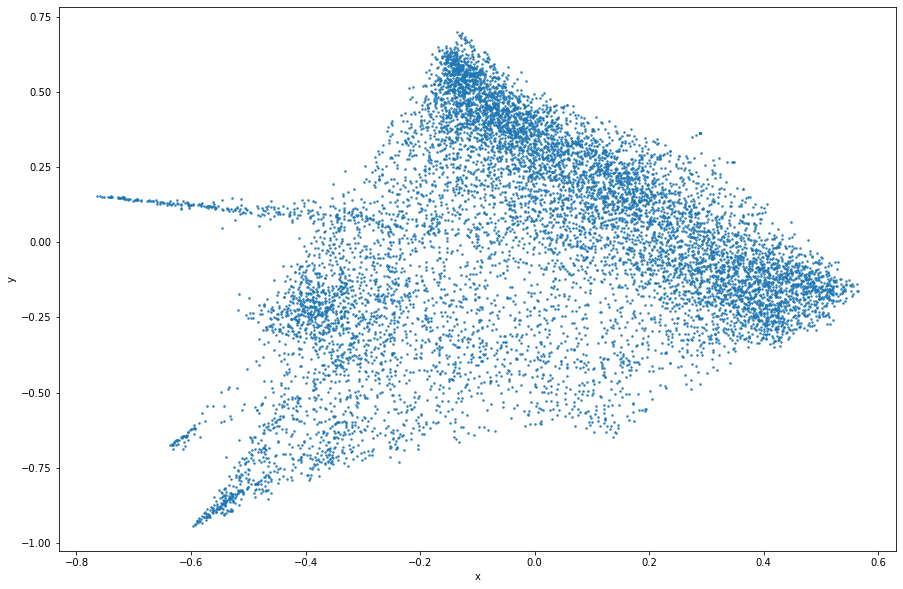

In [31]:
_ = coords_df.plot.scatter('x', 
                           'y', 
                           figsize=(15,10), 
                           marker='.', 
                           s=10, 
                           alpha=.8)

In [35]:
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure


In [41]:
output_notebook()

subset_df = coords_df.sample(n=5000)
p =  figure(plot_width=1000, plot_height=700)
_ = p.text(x=subset_df.x, y=subset_df.y, text=subset_df.token)
show(p)

Loading BokehJS ...

In [38]:
# Save the file
bokeh.io.output_file("output_file_name.html")

<br>

---

<br>